In [6]:
!pip install wfdb 

In [7]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
import os
def bandpass_filter(signal, lowcut=0.5, highcut=15, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)
def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal

In [8]:
import pandas as pd  # make sure this is imported
from tqdm import tqdm
def create_training_data_from_df_fast(df, fixed_length=250):
    X = []
    Y = []

    mitdb_path = "/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/"
    grouped = df.groupby("record_name")

    for record_name, group in tqdm(grouped, desc="Processing records"):
        full_path = mitdb_path + str(record_name)
        record = wfdb.rdrecord(full_path)

        signal = record.p_signal[:, 0]  # lead I
        fs = record.fs
        if fs != 250:
            signal = resample_signal(signal, original_fs=fs, target_fs=250)
            fs = 250

        signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))

        for _, row in group.iterrows():
            if pd.isna(row['R_reel']):
                continue  # Skip rows with missing R_reel
            #print(row['R_reel'])
            start = int(row['start'])
            end = int(row['end'])
            r_reel = int(row['R_reel'])

            if r_reel < start or r_reel >= end:
                continue

            window = signal[start:end]
            label = np.zeros((end - start, 1))
            label[r_reel - start] = 1

            if len(window) > fixed_length:
                window = window[:fixed_length]
                label = label[:fixed_length]
            elif len(window) < fixed_length:
                pad_width = fixed_length - len(window)
                window = np.pad(window, (0, pad_width), mode='constant')
                label = np.pad(label, ((0, pad_width), (0, 0)), mode='constant')

            window = window.reshape(-1, 1)
            X.append(window)
            Y.append(label)

    return np.array(X), np.array(Y)


In [9]:
import kagglehub
mitdb_features_2_path = kagglehub.dataset_download('abdessamiguebli/mitdb-features-2/versions/5')

In [10]:
df = pd.read_csv(mitdb_features_2_path+'/all_features.csv')
X, Y = create_training_data_from_df_fast(df)


Processing records: 100%|██████████| 48/48 [00:21<00:00,  2.23it/s]


In [11]:
print(df.count()['record_name'])
print(len(X))

108036
106940


In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)



In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Flatten, Dense, Dropout, UpSampling1D

def build_cnn_model(input_length):
    input_layer = Input(shape=(input_length, 1))

    x = Conv1D(32, kernel_size=5, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = UpSampling1D(2)(x)

    x = Conv1D(1, kernel_size=1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=x)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


2025-05-24 19:39:28.457428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748115568.712727      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748115568.788048      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
model = build_cnn_model(input_length=X.shape[1])
model.summary()

2025-05-24 19:39:43.229137: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 250, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 250, 32)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 250, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 250, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 125, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 125, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d (UpSampling1D)         │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 250, 1)              │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,849 (26.75 KB)

 Trainable params: 6,657 (26.00 KB)

 Non-trainable params: 192 (768.00 B)

In [15]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.9905 - loss: 0.0564 - val_accuracy: 0.9958 - val_loss: 0.0094
Epoch 2/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.9960 - loss: 0.0089 - val_accuracy: 0.9959 - val_loss: 0.0088
Epoch 3/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.9960 - loss: 0.0086 - val_accuracy: 0.9960 - val_loss: 0.0086
Epoch 4/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.9960 - loss: 0.0085 - val_accuracy: 0.9960 - val_loss: 0.0084
Epoch 5/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.9960 - loss: 0.0084 - val_accuracy: 0.9958 - val_loss: 0.0088
Epoch 6/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - accuracy: 0.9960 - loss: 0.0083 - val_accuracy: 0.9960 - val_loss: 0.0084
Epoch 7/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.9960 - loss: 0.0083 - val_accuracy: 0.9959 - val_loss: 0.0083
Epoch 8/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - accuracy: 0.9960 -

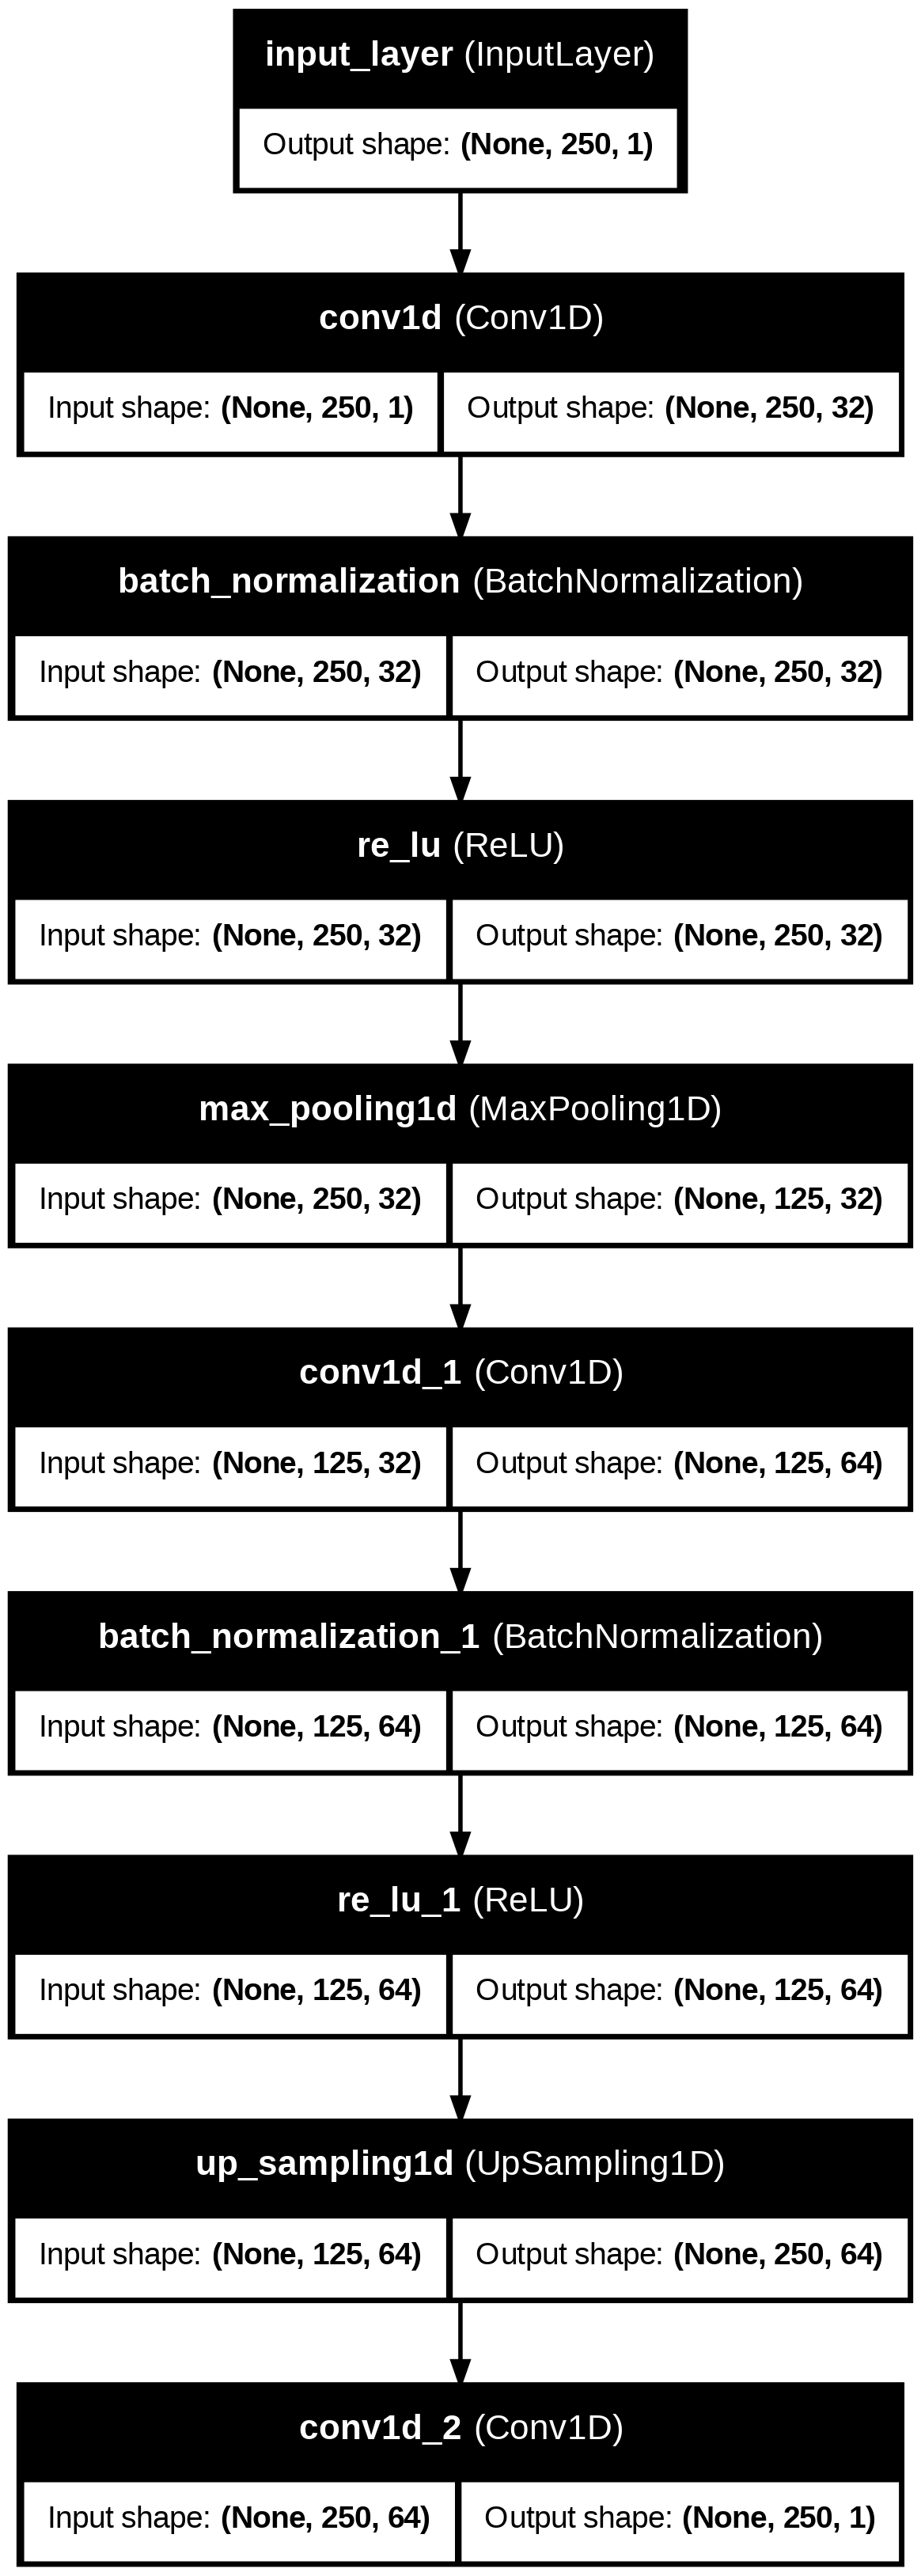

In [16]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

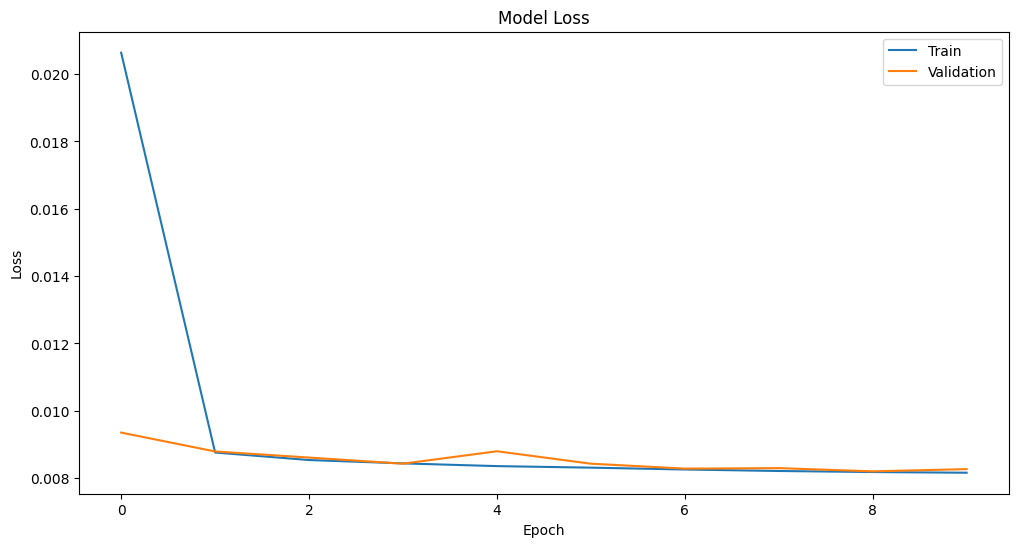

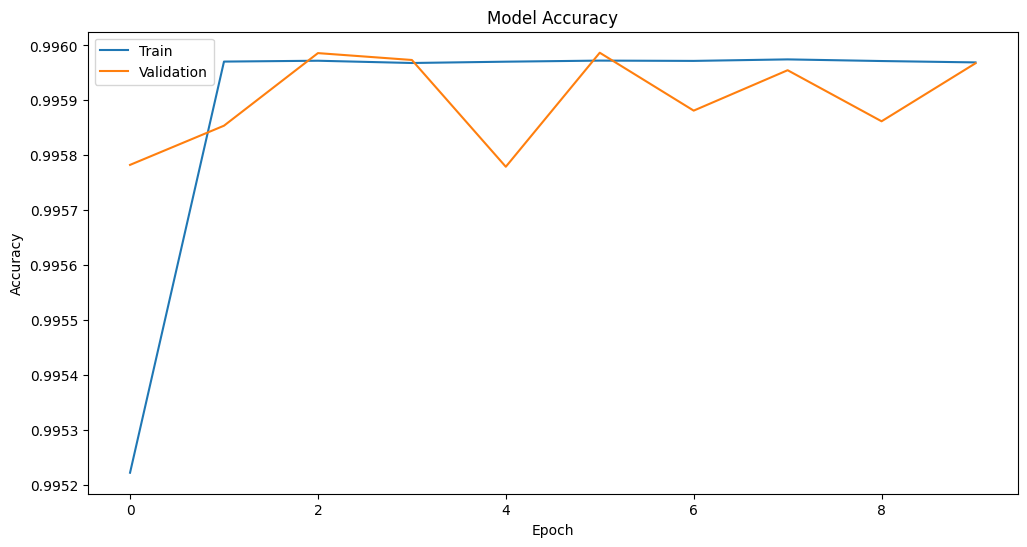

In [17]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
model.save("R_detection.h5")
